Предсказание временных рядов
1. Скачать датасет Х.
2. Используя модель ARIMA из лекции, перебором подобрать наилучший набор параметров.
3. Написать реализацию модели Хольта-Уинтерса (без использования готовых методов из библиотек)
4. Натренировать одну из ML моделей на предсказание значения временного ряда.

Критерии оценки: 
1. Корректность реализации в п.2.
2. Корректно написана реализация в п. 3
3. Корректно реализован выбор модели в п. 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from __future__ import division, print_function

import datetime as dt
from itertools import product
import tqdm
import warnings

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
pd.options.display.max_columns=1000

/Users/mary/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Загрузка данных
Будем разбирать пример с данными из датасета Brooklyn Home Sales, 2003 to 2017 с Kaggle. Посмотрим на количество проданной недвижимости в Бруклине с течением времени. Разбивку сделаем по месяцам.

In [3]:
df_source = pd.read_csv(
    '/Users/mary/Desktop/Otus/Module 3/HW4_TimeSeries/brooklynhomes2003to2017/brooklyn_sales_map.csv')
df = df_source.copy()

In [4]:
df.head(2)

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class,block,lot,easement,building_class,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_sqft,gross_sqft,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,year_of_sale,Borough,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
0,1,3,DOWNTOWN-METROTECH,28 COMMERCIAL CONDOS,4,140,1001,NaN,R5,330 JAY STREET,COURT,11201,0,1,1,0.0,0.0,2002,4,R5,499401179.0,2008-04-23,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3,DOWNTOWN-FULTON FERRY,29 COMMERCIAL GARAGES,4,54,1,NaN,G7,85 JAY STREET,NaN,11201,0,0,0,134988.0,0.0,0,4,G7,345000000.0,2016-12-20,2016,BK,302.0,21.0,3017.0,13.0,33.0,11201.0,L118,84.0,36.0,1000.0,3.0,2.0,1B,87 JAY STREET,M1-2/R8,NaN,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,N,G7,10.0,0.0,P,85 JAY STREET BROOKLY,134988.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,490.5,275.33,0.0,0.0,NaN,0.0,N,5.0,5.0,1571850.0,1571850.0,1571850.0,1571850.0,0.0,0.0,0.0,NaN,NaN,0.0,7.2,2.0,6.5,3.0,3.000540e+09,0.0,21.0,988208.0,195011.0,12d,NaN,302 016,30101.0,NaN,3.000540e+09,12/06/2002,1.0,NaN,NaN,17V1.1,0.0,1559.889144,140131.577176


In [5]:
df.describe()

,Unnamed: 0,borough,block,lot,easement,zip_code,residential_units,commercial_units,total_units,land_sqft,gross_sqft,year_built,tax_class_at_sale,sale_price,year_of_sale,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,PolicePrct,HealthCent,HealthArea,SanitBoro,SanitDistr,LandUse,Easements,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,ProxCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,TaxMap,APPBBL,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
count,390883.000000,390883.0,390883.000000,390883.000000,0.0,390883.000000,390883.000000,390883.000000,390883.000000,3.908830e+05,3.908830e+05,390883.000000,390883.000000,3.908830e+05,390883.000000,303728.000000,303436.000000,302515.000000,303688.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303238.000000,303238.000000,302711.000000,303728.000000,3.037280e+05,3.037280e+05,3.037280e+05,3.037280e+05,3.037280e+05,3.037280e+05,3.037280e+05,3.037280e+05,3.037280e+05,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303706.000000,303706.000000,303706.000000,3.037280e+05,3.037280e+05,3.037280e+05,3.037280e+05,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.000000,303728.0,3.037280e+05,303728.000000,303728.000000,3.037280e+05,303728.000000,303710.000000,3.037280e+05,303728.000000,8653.0,27773.0,303728.000000,303728.000000,3.037280e+05
mean,195442.000000,3.0,4275.651169,272.509986,NaN,11208.429087,2.486138,0.174142,2.673227,2.368464e+03,2.970877e+03,1701.666307,1.642660,5.067545e+05,2009.478243,309.783211,492.221200,1971.065160,19.089803,40.888522,11207.063718,71.830012,34.460293,5758.185060,3.000326,9.776390,2.188791,0.007049,8.459416e+03,2.361238e+04,1.207292e+03,2.221657e+04,1.584349e+02,2.743297e+02,2.489965e+02,1.156844e+02,1.732853e+02,209.225606,2.086038,1.314824,3.102166,22.082923,22.347620,53.086843,109.695027,39.399567,59.381591,1.566637,4.742886,2.439326,1.209784e+05,7.813468e+05,4.136623e+04,8.105911e+04,1879.716700,295.778483,34.019662,1.662472,1.828681,0.153269,2.854437,3.0,3.045066e+09,0.029987,4715.545455,9.921077e+05,175146.073694,31396.728152,1.927884e+08,1.000145,1.0,1.0,0.000244,337.445796,8.645885e+03
std,112838.346973,0.0,2642.765332,484.658837,NaN,361.207836,48.200178,1.653362,48.233343,2.509129e+04,1.453960e+04,636.764362,0.906378,2.353965e+06,4.504907,5.457593,331.650433,992.300369,4.221940,4.648494,382.456905,8.632760,2.514558,2576.513859,0.019130,5.455605,1.912236,0.086297,3.140562e+04,8.164505e+04,1.307823e+04,7.949109e+04,4.274347e+03,3.486221e+03,5.525525e+03,5.206794e+03,5.201557e+03,4586.906650,0.560690,2.247752,2.927788,79.764423,79.954151,99.398538,63.857962,56.369625,43.217604,1.206424,0.701608,1.559428,7.152424e+05,3.227031e+06,2.495788e+05,1.524291e+06,317.759012,710.334178,259.086380,1.549262,1.139002,0.811046,1.428735,0.0,2.571172e+07,8.840051,17545.128104,7.391759e+04,18390.569903,754.905314,7.409608e+08,0.017021,0.0,0.0,0.036740,329.587401,3.116106e+04
min,1.000000,3.0,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000e+00,2003.000000,301.000000,1.000000,1.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,3.000010e+09,0.000000,0.000000,0.000000e+00,0.000000,3.000000,

In [6]:
df.sale_date = pd.to_datetime(df.sale_date)

# Add Year+month column
df['ym'] = df.sale_date.apply(lambda x: x.strftime("%b %Y"))
df.ym = pd.to_datetime(df.ym)

In [7]:
month_sells = df.groupby('ym')[['address']].count().reset_index()
month_sells

,ym,address
0,2003-01-01,2776
1,2003-02-01,2243
2,2003-03-01,2592
3,2003-04-01,2721
4,2003-05-01,2892
5,2003-06-01,3118
6,2003-07-01,2798
7,2003-08-01,2632
8,2003-09-01,2846
9,2003-10-01,3017


In [8]:
month_sells = month_sells.rename(columns={'address':'sales', 'ym':'date'}).set_index('date')
month_sells

,sales
date,
2003-01-01,2776
2003-02-01,2243
2003-03-01,2592
2003-04-01,2721
2003-05-01,2892
2003-06-01,3118
2003-07-01,2798
2003-08-01,2632
2003-09-01,2846


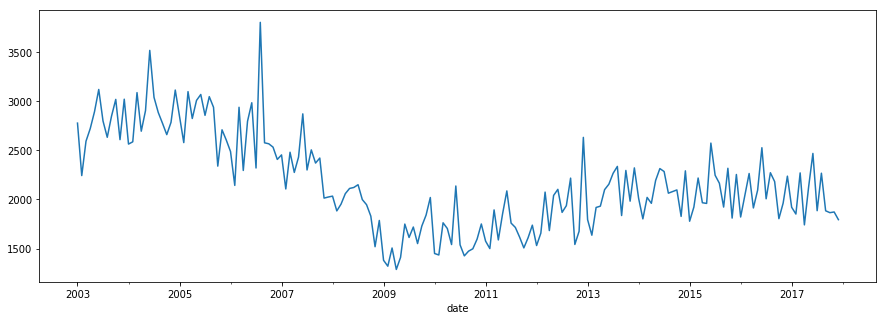

In [9]:
plt.rcParams["figure.figsize"] = (15,5)
month_sells.sales.plot();

## Использование модели ARIMA
### 1) Приведение ряда к стационарному 

Перед использованием модели ARIMA проведем тест на стационарость

In [10]:
time_series = month_sells.sales

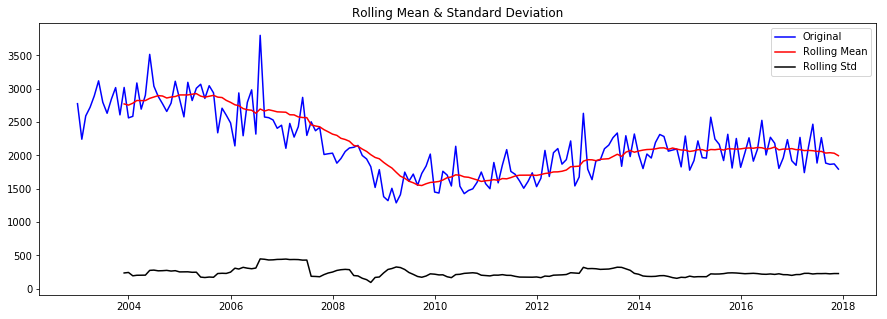

Results of Dickey-Fuller Test:
Test Statistic                  -1.735207
p-value                          0.413070
#Lags Used                      14.000000
Number of Observations Used    165.000000
Critical Value (1%)             -3.470616
Critical Value (5%)             -2.879221
Critical Value (10%)            -2.576197
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Задаем скользящие
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Отрисовываем
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Выполняем тест Дики-Фуллера
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
# plt.figure(figsize=(15,5))
test_stationarity(time_series)

Результат теста показал нестационарность ряда. Попробуем теперь от нее избавиться

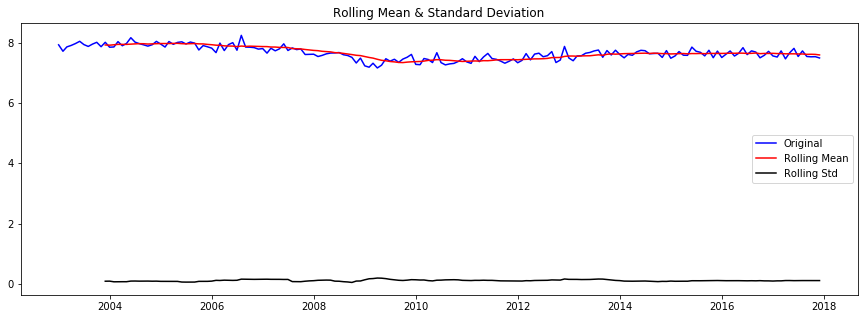

Results of Dickey-Fuller Test:
Test Statistic                  -1.743806
p-value                          0.408695
#Lags Used                      14.000000
Number of Observations Used    165.000000
Critical Value (1%)             -3.470616
Critical Value (5%)             -2.879221
Critical Value (10%)            -2.576197
dtype: float64


In [12]:
# Logarythm
# plt.figure(figsize=(15,5))

series_log = np.log(time_series)
test_stationarity(series_log)

После логарифмирования Р-значение в тесте на стационарность значительно улучшилось на наших данных. Попробуем рассчитать разность:

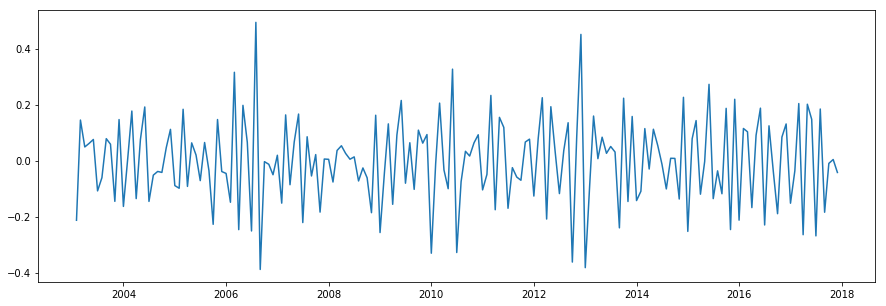

In [13]:
# Differencing
# plt.figure(figsize=(15,5))
series_log_diff = series_log - series_log.shift()
plt.plot(series_log_diff);

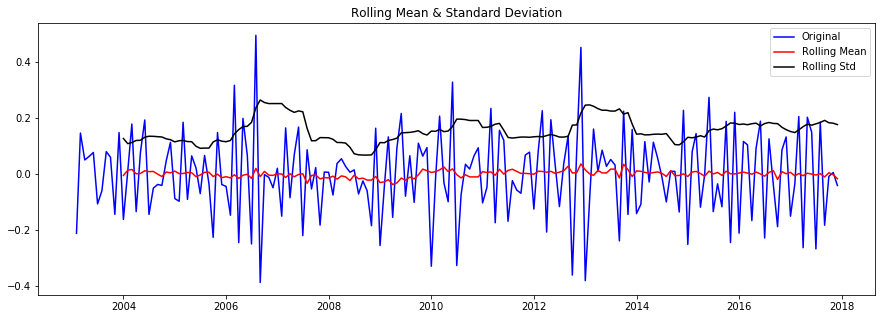

Results of Dickey-Fuller Test:
Test Statistic                  -2.595118
p-value                          0.094010
#Lags Used                      14.000000
Number of Observations Used    164.000000
Critical Value (1%)             -3.470866
Critical Value (5%)             -2.879330
Critical Value (10%)            -2.576255
dtype: float64


In [14]:
# plt.figure(figsize=(15,5))
series_log_diff.dropna(inplace=True)
test_stationarity(series_log_diff)

После рассчета разности результат немного улучшился в сравнении с исходным, посмотрим также декомпозицию

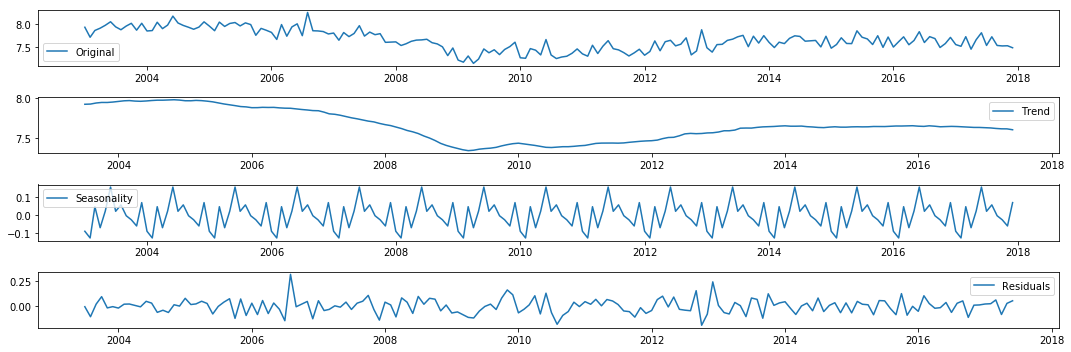

In [15]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(series_log, freq=12) # take 12 months frequency

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(series_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

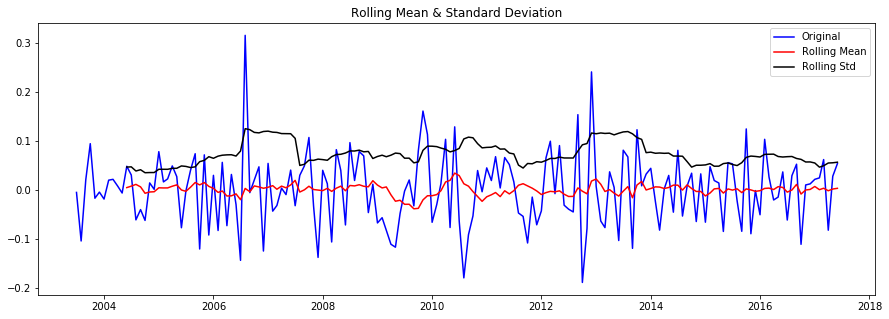

Results of Dickey-Fuller Test:
Test Statistic                -7.280397e+00
p-value                        1.505692e-10
#Lags Used                     1.000000e+01
Number of Observations Used    1.570000e+02
Critical Value (1%)           -3.472703e+00
Critical Value (5%)           -2.880132e+00
Critical Value (10%)          -2.576683e+00
dtype: float64


In [16]:
# plt.figure(figsize=(15,5))
decomposed = residual
decomposed.dropna(inplace=True)
test_stationarity(decomposed)

Декомпозиция значительно снизила Р-значение

### 2) Оценка и настройка параметров модели

In [17]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(series_log_diff, nlags=20)
lag_pacf = pacf(series_log_diff, nlags=20, method='ols')

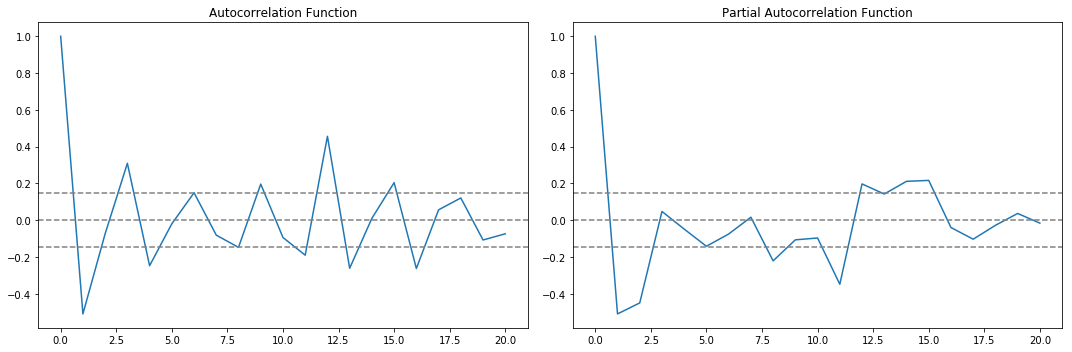

In [18]:
# plt.figure(figsize=(17,5))

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Судя по графикам параметры q, p можно оба взять за единицы

In [19]:
q=1
d=1
p=1

Text(0.5, 1.0, 'RSS: 2.6066')

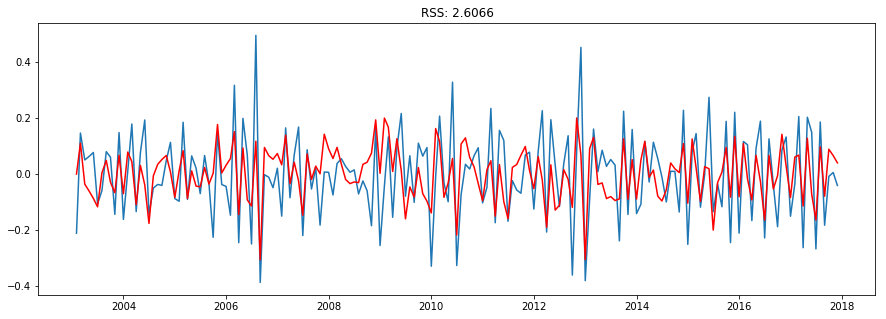

In [22]:
from statsmodels.tsa.arima_model import ARIMA 

model = ARIMA(series_log, order=(p, d, q))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(series_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-series_log_diff)**2))

Судя по графику, модель лишь в некоторых местах неплохо "ловит" волатильность. Посмотрим исходный временной ряд:

Text(0.5, 1.0, 'RMSE: 1733.2184')

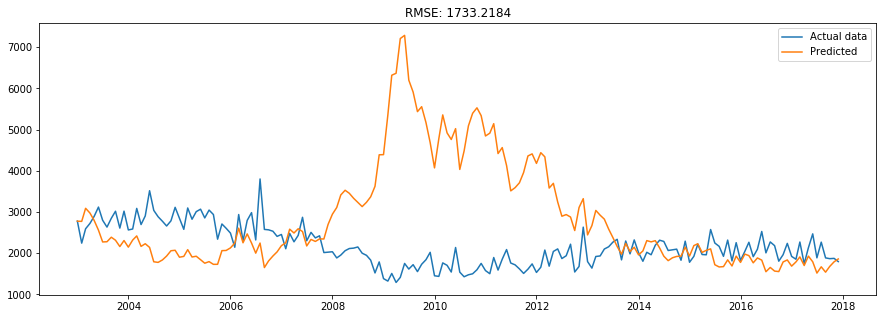

In [23]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() # Inverse diff
predictions_ARIMA_log = pd.Series(series_log.ix[0], index=series_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log) # Inverse logarithming
plt.plot(time_series, label='Actual data')
plt.plot(predictions_ARIMA, label='Predicted')
plt.legend()
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-time_series)**2)/len(time_series)))

Как видим, предсказания совсем мимо, попробуем подобрать лучше параметры

In [24]:
p = range(0, 10)
d = (1,)
q = range(0, 2)

parameters = product(p, d, q)
parameters_list = list(parameters)
len(parameters_list)

20

In [25]:
for p, d, q in parameters_list:
    model = ARIMA(series_log, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    rss = sum((results_ARIMA.fittedvalues - series_log_diff)**2)
    print('for p={}, d={}, q={} RSS is {}'.format(p, d, q, rss))


for p=0, d=1, q=0 RSS is 4.179869158545662
for p=0, d=1, q=1 RSS is 2.617252962728008
for p=1, d=1, q=0 RSS is 3.0965169443884113
for p=1, d=1, q=1 RSS is 2.6065841562983807
for p=2, d=1, q=0 RSS is 2.473818000991689
for p=2, d=1, q=1 RSS is 2.467374818949403
for p=3, d=1, q=0 RSS is 2.4682025733274333
for p=3, d=1, q=1 RSS is 2.42889595223495
for p=4, d=1, q=0 RSS is 2.462578514695794
for p=4, d=1, q=1 RSS is 2.3722975495201037
for p=5, d=1, q=0 RSS is 2.414366093847472
for p=5, d=1, q=1 RSS is 2.3468392169851526
for p=6, d=1, q=0 RSS is 2.401331464012959
for p=6, d=1, q=1 RSS is 2.3466218346406102
for p=7, d=1, q=0 RSS is 2.400722028103151
for p=7, d=1, q=1 RSS is 2.3386739128138516
for p=8, d=1, q=0 RSS is 2.2902898982121767
for p=8, d=1, q=1 RSS is 2.226836158025678
for p=9, d=1, q=0 RSS is 2.2658950253807917
for p=9, d=1, q=1 RSS is 2.2245803255685033


### 3) Обучение и итоговое предсказание с помощью ARIMA

Text(0.5, 1.0, 'RSS: 2.4674')

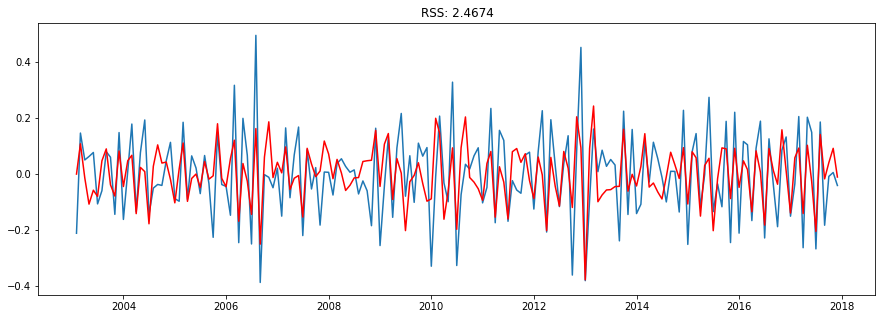

In [26]:
p=2
d=1
q=1

plt.figure(figsize=(15,5))
model = ARIMA(series_log, order=(p, d, q))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(series_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-series_log_diff)**2))

Text(0.5, 1.0, 'RMSE: 967.7026')

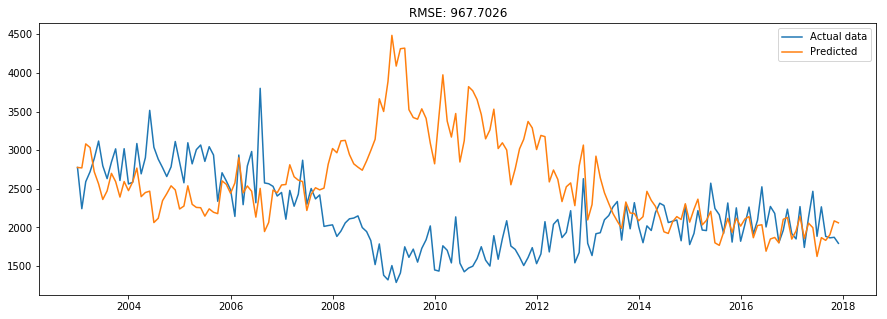

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() # Inverse diff
predictions_ARIMA_log = pd.Series(series_log.ix[0], index=series_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log) # Inverse logarithming
plt.plot(time_series, label='Actual data')
plt.plot(predictions_ARIMA, label='Predicted')
plt.legend()
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-time_series)**2)/len(time_series)))

Результат немного улучшился: снизился RMSE, и визуально ряд приблизился к исходному

## Использование Holt-Winters модели 
### 1) Реализация модели Holt-Winters

In [29]:
class HoltWinters():
    '''
    Creates Holt-Winters model.
    
    series - time series numpy array
    slen - length of season
    alpha, beta, gamma - coefficients of model
    n_preds - number of predictions
    '''
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds):
        self.series=series
        self.slen=slen
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.n_preds=n_preds
        self.result=[]
    
    def get_seasonal_components(self):
        seasonal_c = {}
        n_seasons = int(len(self.series)/self.slen)
        season_averages = \
            [sum(self.series[self.slen*i:self.slen*i+self.slen])/float(self.slen) for i in range(n_seasons)]

        for i in range(self.slen):
            seasonal_c[i] = \
                np.sum([self.series[self.slen*j+i]-season_averages[j] for j in range(n_seasons)])/n_seasons
        return seasonal_c

    
    def triple_exponential_smoothing(self):
        seasonal_c = self.get_seasonal_components()
        for i in range(len(self.series) + self.n_preds):
            if i == 0:
                smooth = self.series[0]
                trend = np.sum(
                    [float(self.series[i+self.slen] - self.series[i]) / self.slen for i in range(self.slen)])\
                    /self.slen
                self.result.append(self.series[0])
                continue
            if i >= len(self.series): 
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonal_c[i%self.slen])
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val - seasonal_c[i % self.slen]) + (1 - self.alpha)*(smooth + trend)
                trend = self.beta*(smooth / last_smooth) + (1 - self.beta)*trend # use multiplicative
                seasonal_c[i % self.slen] = self.gamma*(val - smooth) + (1 - self.gamma)*seasonal_c[i % self.slen]
                self.result.append(smooth + trend + seasonal_c[i % self.slen])
        return 
    
    def result(self):
        return self.result

### 2) Применение модели на наших данных

In [30]:
from sklearn.model_selection import TimeSeriesSplit
slen=12

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen = slen, alpha=alpha, 
                            beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [31]:
%%time
data = time_series[:-20] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.5569349803997375 1.0 0.0
CPU times: user 2.51 s, sys: 20.6 ms, total: 2.53 s
Wall time: 2.54 s


In [32]:
import datetime

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = 1
    return dt.date(year, month, day)


n_preds=12
model = HoltWinters(series=time_series, slen = slen, alpha=alpha_final, 
                    beta=beta_final, gamma=gamma_final, n_preds=n_preds)
model.triple_exponential_smoothing()

addind_index=[add_months(time_series.index[len(time_series)-1], i) for i in range(1,n_preds+1)]
indices = pd.concat([pd.Series(time_series.index), pd.Series(addind_index)], axis=0)
predictions = pd.Series(model.result, index=indices)

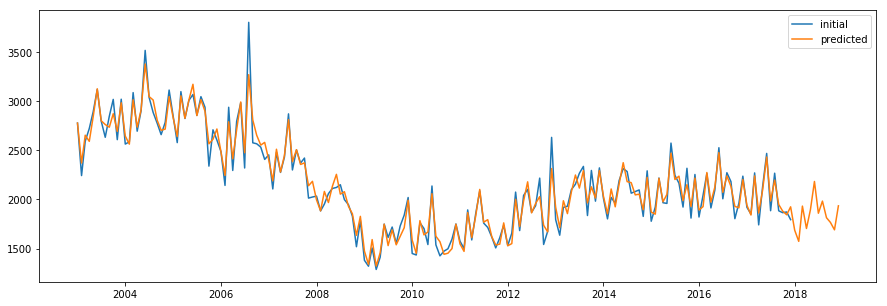

In [33]:
# plt.figure(figsize=(15,5))
plt.plot(time_series,label='initial');
plt.plot(predictions,label='predicted');
plt.legend();

Тройное экспоненциальное сглаживание отработало очень хорошо: смоделированный ряд достаточно точно описывает исходный

## Использование модели машинного обучения

Возьмем в качестве алгоритма градиентный бустинг, а к признакам добавим сдвинутые на месяц, квартал, год, полтора года.

In [68]:
d = month_sells
d.head(3)

,sales,month_ago_close,quarter_ago_close,year_ago_close,yearnhalf_ago_close
date,,,,,
2003-01-01,2776,NaN,NaN,NaN,NaN
2003-02-01,2243,2776.0,NaN,NaN,NaN
2003-03-01,2592,2243.0,NaN,NaN,NaN


In [69]:
d['month_ago_close'] = d.sales.shift(1)
d['two_month_ago_close'] = d.sales.shift(2)
d['quarter_ago_close'] = d.sales.shift(3)
d['half_year_ago_close'] = d.sales.shift(6)
d['year_ago_close'] = d.sales.shift(12)
d['yearnhalf_ago_close'] = d.sales.shift(18)

In [70]:
d=d.dropna()
d=d.reset_index()
d['date'] = d['date'].astype(int) # d['date'].astype('datetime64[ns]')

print(d.shape)
d.head(3)

(162, 8)


,date,sales,month_ago_close,quarter_ago_close,year_ago_close,yearnhalf_ago_close,two_month_ago_close,half_year_ago_close
0,1088640000000000000,3038,3515.0,2694.0,2798.0,2776.0,2903.0,2563.0
1,1091318400000000000,2884,3038.0,2903.0,2632.0,2243.0,3515.0,2586.0
2,1093996800000000000,2774,2884.0,3515.0,2846.0,2592.0,3038.0,3086.0


In [71]:
mean_error = []

for mon in d.date[1:]:
    train = d[d.date < mon]
    test = d[d.date == mon]
    
    x_train, x_test = train.drop('sales', axis=1), test.drop('sales', axis=1)
    y_train, y_test = train['sales'].values, test['sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(x_train, y_train)
    y_pred = mdl.predict(x_test)
    
    error = np.sqrt(mean_squared_error(y_test, y_pred))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))
    

Mean Error = 221.56915


In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(d.drop('sales', axis = 1), d.sales, 
                                                    test_size = 0.25, random_state = 42)
lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
lgbm.fit(X_train, Y_train)
Y_pred = lgbm.predict(X_test)

error = np.sqrt(mean_squared_log_error(Y_test, Y_pred))

In [73]:
error

0.1259153683864936

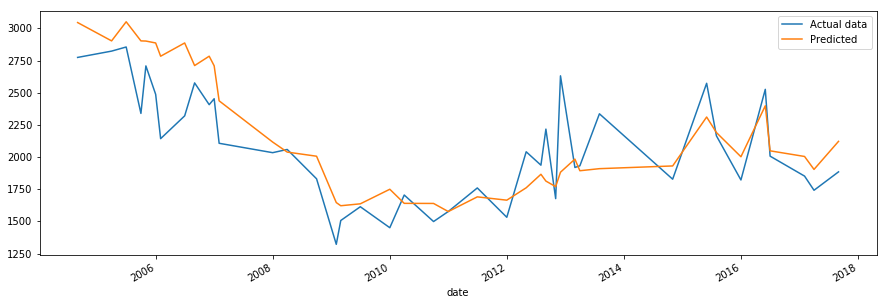

In [74]:
pd.Series(np.array(Y_test), index = pd.to_datetime(X_test.date)).plot(label='Actual data');
pd.Series(np.array(Y_pred), index = pd.to_datetime(X_test.date)).plot(label='Predicted');
plt.legend();

In [75]:
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

def my_custom_loss_func(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

myscorer = make_scorer(my_custom_loss_func, greater_is_better=False)


t=time()
param_grid = {
    'n_estimators': [10, 50, 300, 500, 700, 1000, 10000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]
}

gs = GridSearchCV(LGBMRegressor(), param_grid, scoring=myscorer, cv=3)

gs.fit(d.drop('sales', axis = 1), d.sales)

print('Time spend: {} mins'.format(round((time() - t) / 60, 2)))
# best RMSE score
# print(gs.best_score['rmse'])

Time spend: 0.43 mins


In [77]:
gs.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [78]:
# learning_rate=0.01, n_estimators=700
param_grid = {
    'n_estimators': [600, 650, 700, 750, 800, 850, 900],
    'learning_rate': [0.005, 0.01, 0.15]
}

gs = GridSearchCV(LGBMRegressor(), param_grid, scoring=myscorer, cv=3)
gs.fit(d.drop('sales', axis = 1), d.sales)

gs.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=750, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [83]:
gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 750}

Нашли оптимальные параметры для модели: learning_rate=0.01, n_estimators=750

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(d.drop('sales', axis = 1), d.sales, 
                                                    test_size = 0.25, random_state = 42)
lgbm = LGBMRegressor(n_estimators=750, learning_rate=0.01)
lgbm.fit(X_train, Y_train)
Y_pred = lgbm.predict(X_test)

error = np.sqrt(mean_squared_log_error(Y_test, Y_pred))

In [81]:
error

0.12559349935128256

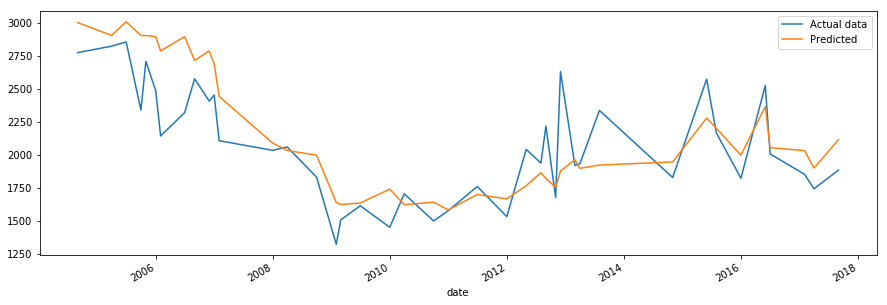

In [82]:
pd.Series(np.array(Y_test), index = pd.to_datetime(X_test.date)).plot(label='Actual data');
pd.Series(np.array(Y_pred), index = pd.to_datetime(X_test.date)).plot(label='Predicted');
plt.legend();

Предсказание ловит не всю волатильность, но, в целом, достаточно близко к реальным данным 

In [84]:
from sklearn.ensemble import RandomForestRegressor

t=time()
param_grid = {
    'n_estimators': [10, 50, 300, 500, 700, 1000, 10000]
}

gs = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=0), param_grid, scoring=myscorer, cv=3)

gs.fit(d.drop('sales', axis = 1), d.sales)

print('Time spend: {} mins'.format(round((time() - t) / 60, 2)))
gs.best_params_

Time spend: 0.84 mins


{'n_estimators': 300}

Error: 0.11650855099498006


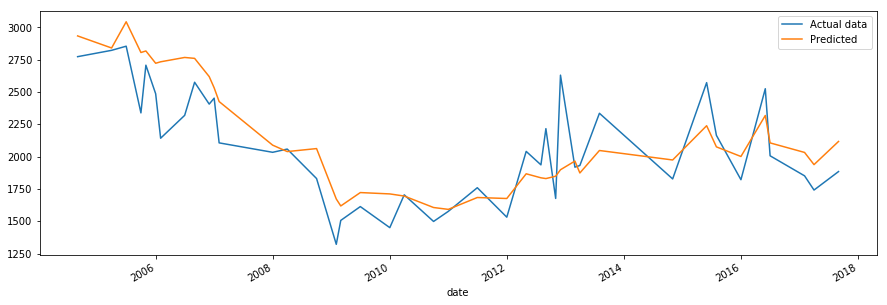

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(d.drop('sales', axis = 1), d.sales, 
                                                    test_size = 0.25, random_state = 42)
lgbm = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=300)
lgbm.fit(X_train, Y_train)
Y_pred = lgbm.predict(X_test)

error = np.sqrt(mean_squared_log_error(Y_test, Y_pred))
print('Error: ' + str(error))

pd.Series(np.array(Y_test), index = pd.to_datetime(X_test.date)).plot(label='Actual data');
pd.Series(np.array(Y_pred), index = pd.to_datetime(X_test.date)).plot(label='Predicted');
plt.legend();

При использовании случайного леса ошибка снизилась в 2 раза, предсказания стали лучше ловить волатильность